## 泰坦尼克乘客生存预测

### 数据集加载

In [1]:
import pandas as pd
import numpy as np
import os

base_dir=r'./titanic/'
train_dir=os.path.join(base_dir,'train.csv')
test_dir=os.path.join(base_dir,'test.csv')

train_data=pd.read_csv(train_dir)
test_data=pd.read_csv(test_dir)

print('train_data shape:',train_data.shape)
print('test_data shape:',test_data.shape)

train_data shape: (891, 12)
test_data shape: (418, 11)


### 数据探索

In [2]:
# 数据信息
print(train_data.info())
print('-'*30)
print(test_data.info())
print('-'*30)
print(train_data.describe())
print('-'*30)
print(train_data.describe(include=['O']))
print('-'*30)
print(train_data.head())
print('-'*30)
print(train_data.tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null obje

### 观察以上数据发现Age、Cabin和Embarked三个字段有缺失，计算出相应缺失率

In [3]:
## 字段缺失率
train_age_missing_rate=1-np.sum(train_data['Age'].value_counts())/train_data.shape[0]
train_cabin_missing_rate=1-np.sum(train_data['Cabin'].value_counts())/train_data.shape[0]
train_embarked_missing_rate=1-np.sum(train_data['Embarked'].value_counts())/train_data.shape[0]

test_age_missing_rate=1-np.sum(test_data['Age'].value_counts())/test_data.shape[0]
test_cabin_missing_rate=1-np.sum(test_data['Cabin'].value_counts())/test_data.shape[0]
test_embarked_missing_rate=1-np.sum(test_data['Embarked'].value_counts())/test_data.shape[0]

print('Age字段缺失率：',train_age_missing_rate,test_age_missing_rate)
print('Cabin字段缺失率：',train_cabin_missing_rate,test_cabin_missing_rate)
print('Embarked字段缺失率：',train_embarked_missing_rate,test_embarked_missing_rate)

Age字段缺失率： 0.19865319865319864 0.20574162679425834
Cabin字段缺失率： 0.771043771043771 0.7822966507177034
Embarked字段缺失率： 0.002244668911335568 0.0


### 数据清洗

In [4]:
# 对年龄使用均值填充
train_data['Age'].fillna(train_data['Age'].mean(),inplace=True)
test_data['Age'].fillna(test_data['Age'].mean(),inplace=True)

# 对Fare使用均值填充
train_data['Fare'].fillna(train_data['Fare'].mean(),inplace=True)
test_data['Fare'].fillna(test_data['Fare'].mean(),inplace=True)

# 对Embarked使用众数填充
train_data['Embarked'].fillna('S',inplace=True)
test_data['Embarked'].fillna('S',inplace=True)


### 特征选择

In [5]:
features=['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']
train_features=train_data[features]
test_features=test_data[features]
train_labels=train_data['Survived']

## 特征数值化

In [6]:
from sklearn.feature_extraction import DictVectorizer
dvec=DictVectorizer(sparse=False)
train_features=dvec.fit_transform(train_features.to_dict(orient='record'))

print(dvec.feature_names_)

['Age', 'Embarked=C', 'Embarked=Q', 'Embarked=S', 'Fare', 'Parch', 'Pclass', 'Sex=female', 'Sex=male', 'SibSp']


### 决策树模型

In [7]:
from sklearn.tree import DecisionTreeClassifier

clf=DecisionTreeClassifier(criterion='entropy')
fit=clf.fit(train_features,train_labels)

### 可视化决策树

In [9]:
from sklearn import tree
import graphviz
import pydotplus
from PIL.Image import Image

dot_tree = tree.export_graphviz(clf,out_file=None)
graph = pydotplus.graph_from_dot_data(dot_tree)
graph.write_svg('decison_tree.svg')

True

### 模型预测& 评估

In [10]:
test_features=dvec.fit_transform(test_features.to_dict(orient='record'))
pred_labels=clf.predict(test_features)
print(pred_labels.shape)

(418,)


In [11]:
acc_decision_tree=round(clf.score(train_features,train_labels),6)
print('score 准确率为 %.4lf' %acc_decision_tree)

score 准确率为 0.9820


### K折交叉验证

In [12]:
import numpy as np

from sklearn.model_selection import cross_val_score

score=np.mean(cross_val_score(clf,train_features,train_labels,cv=10))
print('{:.4f}'.format(score))

0.7813


### ROC曲线

In [13]:
train_labels=train_labels.values
train_labels=train_labels.reshape((train_labels.shape[0],1))
train_labels.shape

(891, 1)

In [20]:
from sklearn.preprocessing import label_binarize
from matplotlib import pyplot as plt
%matplotlib inline

y_true=label_binarize(train_labels,classes=[3,2,1])
y_true=y_true[:,1:3]
print(y_true.shape)
print(y_true[:10,:])

(891, 2)
[[0 0]
 [0 1]
 [0 1]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 1]]


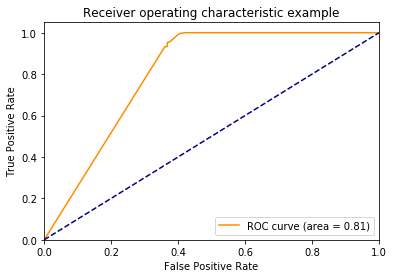

In [21]:
from sklearn.metrics import roc_curve, auc

y_score=clf.predict_proba(train_features)

fpr,tpr,threshold = roc_curve(y_true.ravel(), y_score.ravel()) 
roc_auc = auc(fpr,tpr)
 
plt.figure()
plt.plot(fpr, tpr, color='darkorange',label='ROC curve (area = %0.2f)' % roc_auc) 
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.savefig('roc.svg')
plt.show()

